# Compare double wake results in all cases

Expand comparison to all single wakes occuring in aligned simulations across 8-9 m/s

In [1]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import pickle
from scipy.optimize import minimize

## Load FLORIS models and SOWFA DATA

In [2]:
df = pickle.load( open( "sowfa_04.p", "rb" ) )
# fi_dict = pickle.load( open( "floris_models_2.p", "rb" ) ) # Before retuning TI
fi_dict = pickle.load( open( "floris_models_4.p", "rb" ) ) # After retuning TI
fi_dict

{'g': (<floris.tools.floris_interface.FlorisInterface at 0x105086890>,
  'b',
  's',
  'gauss'),
 'gt': (<floris.tools.floris_interface.FlorisInterface at 0x116d85d50>,
  'r',
  'd',
  'gauss_tune'),
 'gch': (<floris.tools.floris_interface.FlorisInterface at 0x116d9c5d0>,
  'g',
  'o',
  'gch_paper'),
 'leg': (<floris.tools.floris_interface.FlorisInterface at 0x116da1750>,
  'gray',
  '^',
  'legacy'),
 'def': (<floris.tools.floris_interface.FlorisInterface at 0x116da68d0>,
  'orange',
  '*',
  'default')}

In [3]:
# Make a color dict
color_dict = dict()
for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    color_dict[floris_label] = floris_color

# Calculate the power in each case

Make sure now to include yaw angles

In [20]:
# Get the single wake results in all simulations
results_df = pd.DataFrame()

for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]

    # Set up FLORIS to match
    # Determine free-stream wind speed column
    freestream_name = 'freestream_' + floris_label
    

    for i, row in df.iterrows():


        # Match the layout
        if (floris_label == 'gch_paper') or (floris_label == 'legacy'):
            fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                               wind_speed=[row[freestream_name]],
                              turbulence_intensity=[row.floris_TI])
        else:
            fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                                       wind_speed=[row[freestream_name]],
                                      turbulence_intensity=[row.freestream_ti])

        
        fi.calculate_wake(yaw_angles=row.yaw)

        floris_power = np.sum(np.array(fi.get_turbine_power())/1000.)

        sowfa_power = np.sum(row.power)



        result_dict = {'sowfa_power':[sowfa_power],
                       'floris_power':[floris_power],
                       'floris_label':[floris_label],
                       'sowfa_U0':[row.sowfa_U0],
                       'sowfa_TI':[row.sowfa_TI],
                       'yaw':[row.yaw],
                       'layout_x':[row.layout_x],
                       'layout_y':[row.layout_y],
                       'num_turbines':row.num_turbines,
                       'd_spacing':row.d_spacing
                      }

        results_df = results_df.append(pd.DataFrame(result_dict))

results_df.head()

/Users/pfleming/Desktop/git_tools/FLORIS/floris/simulation/wake_velocity/gaussianModels/gaussian_model_base.py:330: RuntimeWarning: overflow encountered in power
  return U * C * np.exp( -1 * r**n / (2 * sigma**2) )
/Users/pfleming/Desktop/git_tools/FLORIS/floris/simulation/wake_velocity/gaussianModels/gauss_legacy.py:88: RuntimeWarning: invalid value encountered in sqrt
  C = 1 - np.sqrt(1 - ( Ct * cosd(yaw) / (8.0 * sigma_y * sigma_z / D**2) ) )


,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing
0,3142.7,3082.951065,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0
0,3009.8,3087.661948,gauss,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0
0,2654.9,2864.673959,gauss,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0
0,2606.5,2652.274229,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0
0,2690.7,2708.595488,gauss,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0


In [21]:
# Assign a baseline power to each row
baseline = []
baseline_sowfa = []
for i, row in results_df.iterrows():
    yaw = row.yaw
    
    # Find the row that is this rows baseline
    df_sub = results_df[(results_df.layout_x == row.layout_x) & 
                        (results_df.layout_y == row.layout_y) & 
                        (results_df.sowfa_U0 == row.sowfa_U0) & 
                        (results_df.sowfa_TI == row.sowfa_TI) & 
                        (results_df.yaw.apply(lambda x: np.max(np.abs(x)))==0.0) &
                        (results_df.floris_label == row.floris_label)]
    if df_sub.shape[0] == 0:
        baseline.append(np.nan)
        baseline_sowfa.append(np.nan)
    else:
        baseline.append(df_sub.floris_power.values[0])
        baseline_sowfa.append(df_sub.sowfa_power.values[0])

results_df['baseline_floris'] = baseline
results_df['baseline_sowfa'] = baseline_sowfa
results_df.head()

,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing,baseline_floris,baseline_sowfa
0,3142.7,3082.951065,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,3087.661948,3009.8
0,3009.8,3087.661948,gauss,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,3087.661948,3009.8
0,2654.9,2864.673959,gauss,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,3087.661948,3009.8
0,2606.5,2652.274229,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,2708.595488,2690.7
0,2690.7,2708.595488,gauss,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,2708.595488,2690.7


In [22]:
# Remove missing values
# plt.plot(results_df.baseline_floris.isnull())
print(results_df.shape)
results_df = results_df[~results_df.baseline_floris.isnull()]
print(results_df.shape)

(3840, 12)
(3840, 12)


In [23]:
# Get a frame of only baseline results
baseline_df = results_df[results_df.yaw.apply(lambda x: np.max(np.abs(x)))==0.0]

In [24]:
# Get baseline errors
baseline_df.head()
baseline_df['error'] = baseline_df.floris_power - baseline_df.sowfa_power

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
# drop the baseline cases
print(results_df.shape)
results_df = results_df[results_df.yaw.apply(lambda x: np.max(np.abs(x)))!=0.0]
print(results_df.shape)

(3840, 12)
(3070, 12)


In [26]:
# compute the gains
results_df['sowfa_gain'] = results_df.sowfa_power - results_df.baseline_sowfa
results_df['sowfa_gain_nom'] = 100. * (results_df.sowfa_power - results_df.baseline_sowfa) / results_df.baseline_sowfa
results_df['floris_gain'] = results_df.floris_power - results_df.baseline_floris
results_df['floris_gain_nom'] = 100. * (results_df.floris_power - results_df.baseline_floris) / results_df.baseline_floris

In [27]:
results_df.head()

,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing,baseline_floris,baseline_sowfa,sowfa_gain,sowfa_gain_nom,floris_gain,floris_gain_nom
0,3142.7,3082.951065,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,3087.661948,3009.8,132.9,4.415576,-4.710883,-0.152571
0,2654.9,2864.673959,gauss,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,3087.661948,3009.8,-354.9,-11.791481,-222.987989,-7.221904
0,2606.5,2652.274229,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,2708.595488,2690.7,-84.2,-3.129297,-56.321259,-2.079353
0,2727.8,2796.193212,gauss,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,2708.595488,2690.7,37.1,1.378823,87.597724,3.234064
0,2721.4,2614.292268,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1063.0)",2,5.0,3085.851769,3154.0,-432.6,-13.715916,-471.559501,-15.281340


In [28]:
# Consider the error in computing the aligned cases
to_plot = baseline_df[['error','floris_label','num_turbines']].groupby(['floris_label','num_turbines']).agg([len,np.mean,np.median,lambda x: np.sqrt(np.sum(x**2)/len(x))])#.reset_index()
to_plot.columns = [c[1] for c in to_plot.columns]
to_plot = to_plot.reset_index()
to_plot['len_val'] = to_plot.len.astype(int)
to_plot

,floris_label,num_turbines,len,mean,median,<lambda>,len_val
0,default,2,95.0,-166.771235,-34.641485,437.353487,95
1,default,3,25.0,136.929237,130.498940,233.610713,25
2,default,4,10.0,174.333640,159.069731,201.014645,10
3,default,5,3.0,238.180787,250.735394,307.196629,3
4,default,6,1.0,1974.599725,1974.599725,1974.599725,1
5,default,9,3.0,740.351733,487.627089,861.339013,3
6,default,12,13.0,141.161291,68.084459,613.590774,13
7,default,38,4.0,1689.466181,1650.807630,2239.809460,4
8,gauss,2,95.0,-166.771235,-34.641485,437.353487,95
9,gauss,3,25.0,136.929237,130.498940,233.610713,25


/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


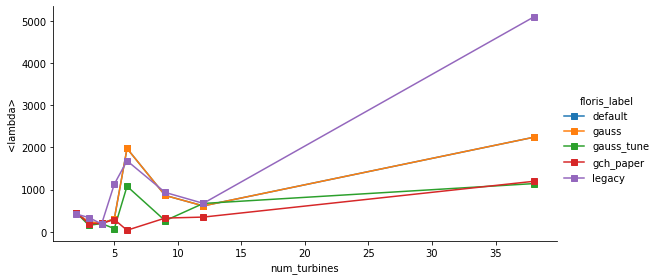

In [32]:
g = sns.FacetGrid(to_plot,hue='floris_label',aspect=2,size=4)
g.map(plt.plot,'num_turbines','<lambda>',marker='s')
# g.map(plt.scatter,'num_turbines','<lambda>',s='len_val')
g.add_legend()

In [33]:
# Consider the error in computing the aligned cases
baseline_df[['error','floris_label']].groupby(['floris_label']).agg([np.mean,np.median,lambda x: np.sqrt(np.sum(x**2)/len(x))])


error                       
                    mean     median    <lambda>
floris_label                                   
default        18.353629  31.079133  577.214009
gauss          18.353629  31.079133  577.214009
gauss_tune   -109.591978 -11.956529  461.369525
gch_paper     -93.351780 -25.375639  430.795823
legacy        170.724678  67.019556  949.009098

In [31]:
results_df[(results_df.num_turbines==2) & (results_df.sowfa_gain>300)]

,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing,baseline_floris,baseline_sowfa,sowfa_gain,sowfa_gain_nom,floris_gain,floris_gain_nom
0,6544.2,5295.630458,gauss,10.0,0.06,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,5164.319078,5904.1,640.1,10.841619,131.311380,2.542666
0,6786.1,5752.437115,gauss,10.0,0.06,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1063.0)",2,5.0,5164.326964,6228.4,557.7,8.954146,588.110151,11.387934
0,6685.7,5389.543638,gauss,10.0,0.06,"[-20.0, 0.0]","(1000.0, 1882.0)","(1000.0, 937.0)",2,7.0,5281.773625,5997.6,688.1,11.472923,107.770013,2.040413
0,5640.0,4899.349753,gauss,10.0,0.06,"[20.0, 0.0]","(1000.0, 1882.0)","(1000.0, 1000.0)",2,7.0,4610.301409,5252.8,387.2,7.371307,289.048344,6.269619
0,6918.6,5906.505983,gauss,10.0,0.06,"[20.0, 0.0]","(1000.0, 1882.0)","(1000.0, 1063.0)",2,7.0,5281.782415,6378.5,540.1,8.467508,624.723568,11.827893
0,6729.3,5456.004558,gauss,10.0,0.06,"[-20.0, 0.0]","(1000.0, 2260.0)","(1000.0, 937.0)",2,10.0,5463.874283,6139.3,590.0,9.610216,-7.869725,-0.144032
0,6137.3,5287.112018,gauss,10.0,0.06,"[20.0, 0.0]","(1000.0, 2260.0)","(1000.0, 1000.0)",2,10.0,5045.855133,5696.6,440.7,7.736194,241.256885,4.781288
0,6951.3,6003.816303,gauss,10.0,0.06,"[20.0, 0.0]","(1000.0, 2260.0)","(1000.0, 1063.0)",2,10.0,5463.883628,6545.5,405.8,6.199679,539.932675,9.881848
0,7614.9,7043.201340,gauss,11.0,0.06,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,6893.780591,7003.3,611.6,8.733026,149.420749,2.167472
0,7537.4,7624.309422,gauss,11.0,0.06,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1063.0)",2,5.0,6893.790915,7046.3,491.1,6.969615,730.518507,10.596760


In [15]:
## %matplotlib

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


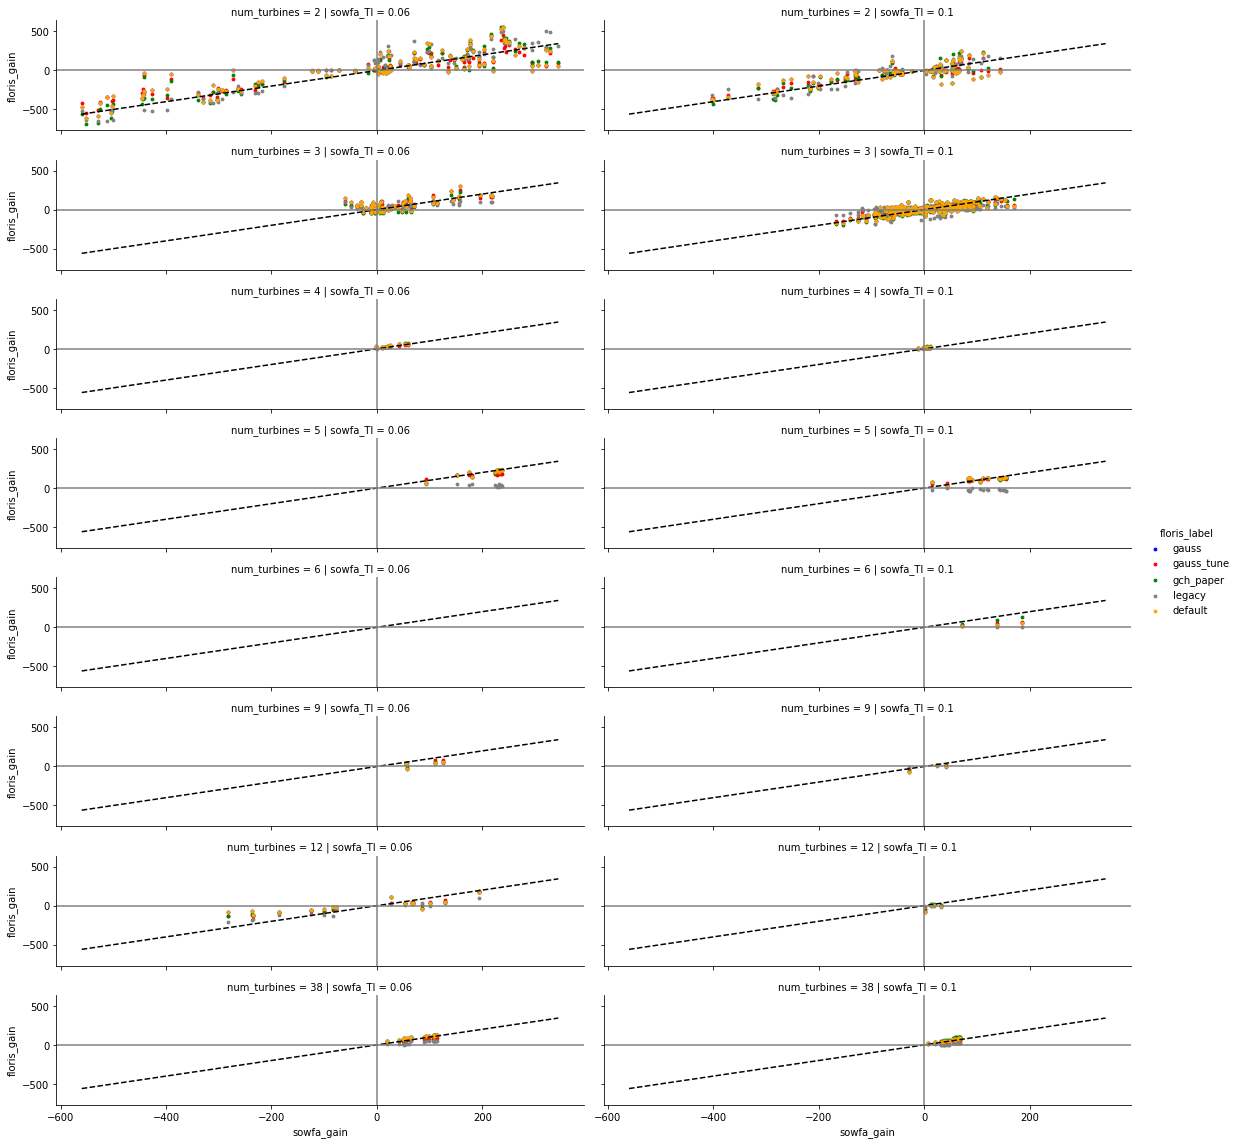

In [16]:
# Compare the gains at the start
use_nominal = False

if use_nominal:
    sowfa_signal = 'sowfa_gain_nom'
    floris_signal = 'floris_gain_nom'
else:
    sowfa_signal = 'sowfa_gain'
    floris_signal = 'floris_gain'    
g = sns.FacetGrid(results_df, row='num_turbines',col='sowfa_TI',hue='floris_label',palette=color_dict,aspect=4,size=2)
g.map(plt.scatter,sowfa_signal,floris_signal,s=8)
for ax in g.axes.flatten():
    ax.plot([results_df[sowfa_signal].min(),results_df[sowfa_signal].max()],
            [results_df[sowfa_signal].min(),results_df[sowfa_signal].max()],'k--')
    ax.axhline(0,color='gray')
    ax.axvline(0,color='gray')
g.add_legend()

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


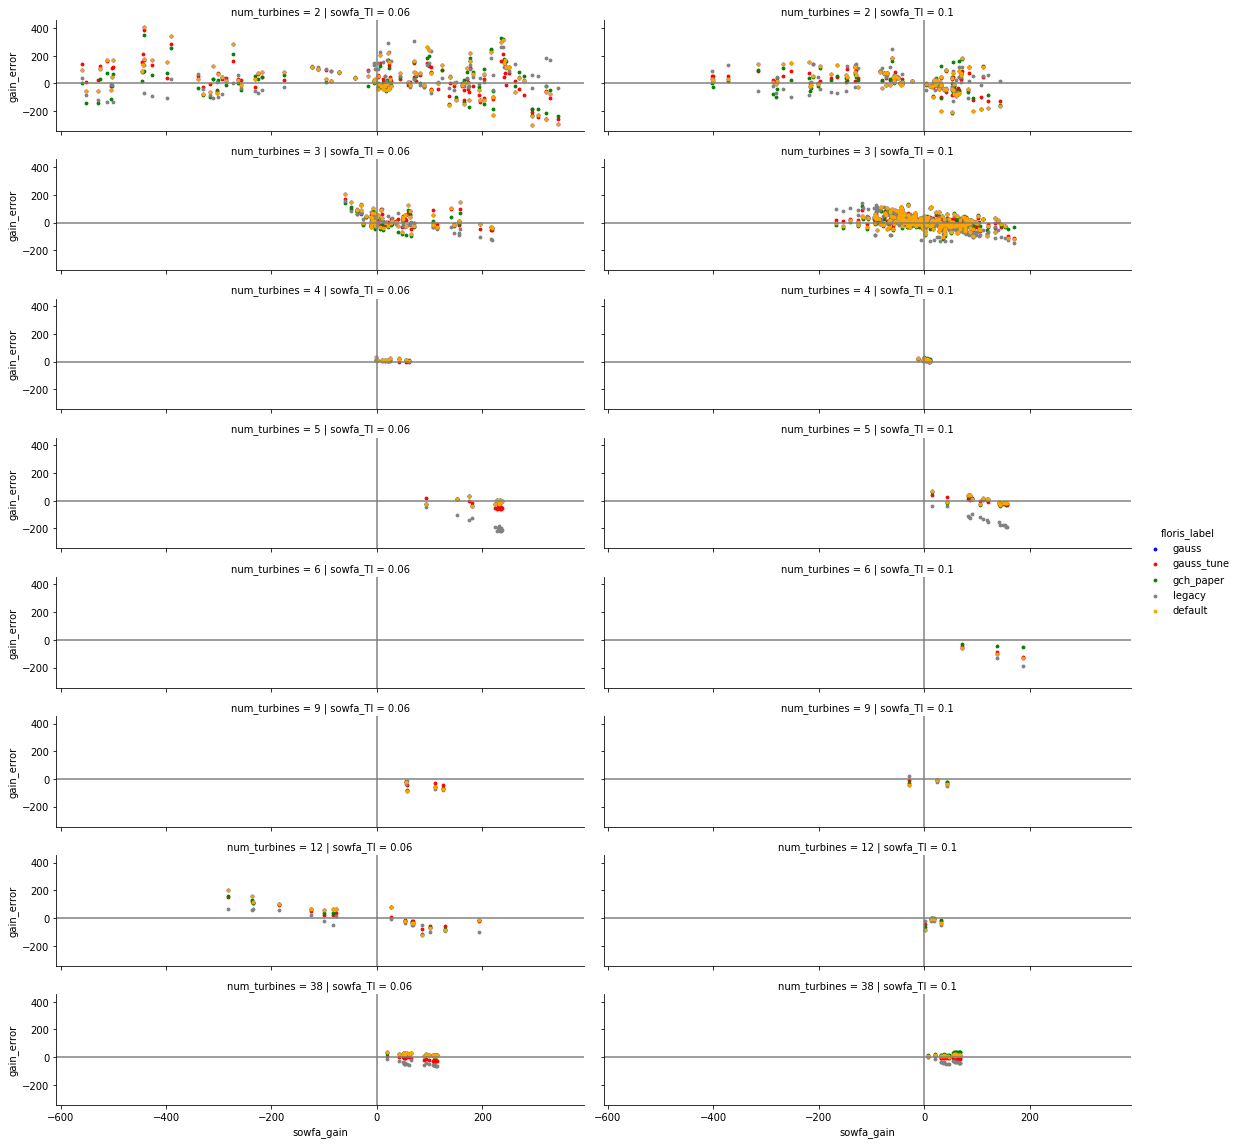

In [17]:
# Compare in terms of error
results_df['gain_error'] = results_df.floris_gain - results_df.sowfa_gain

g = sns.FacetGrid(results_df, row='num_turbines',col='sowfa_TI',hue='floris_label',palette=color_dict,aspect=4,size=2)
g.map(plt.scatter,sowfa_signal,'gain_error',s=8)
for ax in g.axes.flatten():
#     ax.plot([results_df[sowfa_signal].min(),results_df[sowfa_signal].max()],
#             [results_df[sowfa_signal].min(),results_df[sowfa_signal].max()],'k--')
    ax.axhline(0,color='gray')
    ax.axvline(0,color='gray')
g.add_legend()

In [18]:
## Look at RMS error
# Check for an overall bias and rms
results_df[['gain_error','floris_label']].groupby('floris_label').agg([np.mean,np.median,lambda x: np.sqrt(np.sum(x**2)/len(x))])



gain_error                      
                   mean     median   <lambda>
floris_label                                 
default       14.849487  11.336301  75.203033
gauss         14.849487  11.336301  75.203033
gauss_tune    12.027136   7.018541  59.093651
gch_paper      9.572672   7.127876  65.619215
legacy        -3.092608  -5.327304  75.508715

In [19]:
results_df[['gain_error','floris_label','num_turbines']].groupby(['floris_label','num_turbines']).agg([np.mean,np.median,lambda x: np.sqrt(np.sum(x**2)/len(x))])


gain_error                        
                                 mean      median    <lambda>
floris_label num_turbines                                    
default      2              26.512585   18.404972  115.226695
             3              10.477671    6.152455   48.157456
             4              14.882815   13.230184   16.698243
             5               1.736593   -0.753571   25.669381
             6             -99.521056 -104.947917  104.135769
             9             -46.322814  -44.385387   52.397265
             12             18.985459   -4.864070   85.339779
             38             17.590925   17.051824   19.059063
gauss        2              26.512585   18.404972  115.226695
             3              10.477671    6.152455   48.157456
             4              14.882815   13.230184   16.698243
             5               1.736593   -0.753571   25.669381
             6             -99.521056 -104.947917  104.135769
             9             -46.322814  -44.385387   52.397265
             12             18.985459   -4.864070   85.339779
             38             17.590925   17.051824   19.059063
gauss_tune   2              22.889726   21.853781   91.209816
             3              13.112094   10.727110   36.863891
             4               5.224103    4.922966    7.417226
             5             -15.140512  -14.768206   32.018110
             6             -84.113286  -87.087752   90.166886
             9             -25.061486  -25.149266   29.017214
             12             12.267495   -3.249504   62.165698
             38             -8.805969   -7.021066   13.941297
gch_paper    2              17.324451   10.622882   99.691943
             3               4.512870   -0.529516   43.473638
             4              15.327267   13.416699   16.455074
             5              -2.016169   -3.012854   25.513016
             6             -40.923795  -43.177020   41.795253
             9             -39.863133  -29.431965   47.121546
             12             16.227021    2.898922   72.748332
             38             22.494973   20.036638   24.132896
legacy       2              32.229443   18.015025   91.180679
             3              -3.683485    0.799808   57.797049
             4               8.014075    5.670759   11.376406
             5            -148.063411 -153.155439  156.880205
             6            -125.666100 -129.157617  136.136426
             9             -37.600054  -37.546919   50.120833
             12            -18.753746  -22.312506   54.462947
             38            -42.119236  -43.180101   44.270109

In [26]:
# Is there a pattern to where yar struggles
df_sub = results_df[results_df.num_turbines==2]
df_sub = df_sub[df_sub.floris_label=='gauss_tune']

In [29]:
df_sub.sort_values('sowfa_gain')

,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing,baseline_floris,baseline_sowfa,sowfa_gain,sowfa_gain_nom,floris_gain,floris_gain_nom,gain_error
0,2629.35,2224.435076,gauss_tune,10.0,0.06,"[-20.0, 0.0]","(1000.0, 1882.0)","(1000.0, 1063.0)",2,7.0,2642.483025,3189.25,-559.90,-17.555852,-418.047949,-15.820270,141.852051
0,3053.30,2983.399481,gauss_tune,11.0,0.06,"[-20.0, 0.0]","(1000.0, 1882.0)","(1000.0, 1063.0)",2,7.0,3525.838525,3605.00,-551.70,-15.303745,-542.439044,-15.384682,9.260956
0,2993.90,2990.095244,gauss_tune,11.0,0.06,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1063.0)",2,5.0,3493.957003,3523.15,-529.25,-15.022068,-503.861759,-14.420949,25.388241
0,2747.55,2292.143520,gauss_tune,10.0,0.06,"[-20.0, 0.0]","(1000.0, 2260.0)","(1000.0, 1063.0)",2,10.0,2690.850756,3272.75,-525.20,-16.047666,-398.707236,-14.817144,126.492764
0,2989.65,3147.421779,gauss_tune,11.0,0.06,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,3493.952880,3501.65,-512.00,-14.621678,-346.531101,-9.918024,165.468899
0,3211.70,3068.377647,gauss_tune,11.0,0.06,"[-20.0, 0.0]","(1000.0, 2260.0)","(1000.0, 1063.0)",2,10.0,3587.891188,3715.15,-503.45,-13.551270,-519.513541,-14.479635,-16.063541
0,2612.40,2226.245644,gauss_tune,10.0,0.06,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1063.0)",2,5.0,2617.194588,3114.20,-501.80,-16.113288,-390.948943,-14.937710,110.851057
0,3093.85,3144.125272,gauss_tune,11.0,0.06,"[20.0, 0.0]","(1000.0, 1882.0)","(1000.0, 937.0)",2,7.0,3525.834221,3593.70,-499.85,-13.909063,-381.708949,-10.826061,118.141051
0,4174.15,4176.801725,gauss_tune,12.0,0.06,"[-20.0, 0.0]","(1000.0, 1882.0)","(1000.0, 1063.0)",2,7.0,4466.064200,4619.65,-445.50,-9.643588,-289.262475,-6.476899,156.237525
0,4147.95,4205.697424,gauss_tune,12.0,0.06,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1063.0)",2,5.0,4440.296678,4592.50,-444.55,-9.679913,-234.599254,-5.283414,209.950746


In [37]:
df_sub['yaw_0'] = df_sub.yaw.apply(lambda x: x[0])
df_sub['offset'] = df_sub.layout_y.apply(lambda x: (x[1]-1000)/126.)
df_sub['sowfa']

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


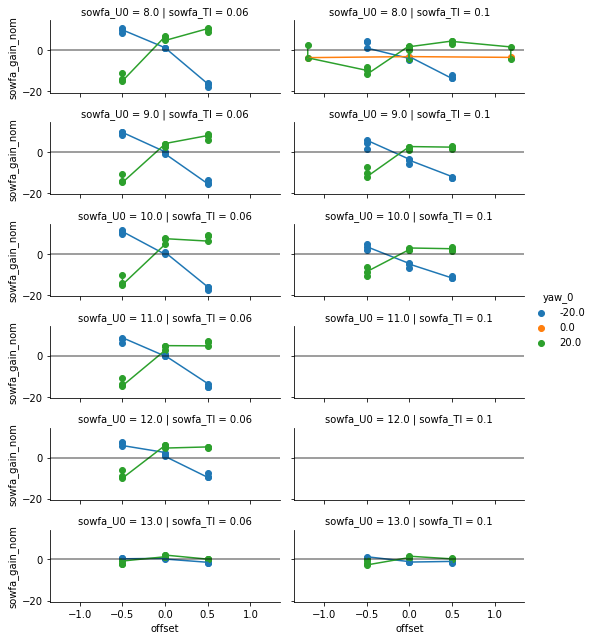

In [59]:
g = sns.FacetGrid(df_sub.sort_values('offset'),row='sowfa_U0',col='sowfa_TI',hue='yaw_0',size=1.5,aspect=2.5)
g.map(plt.plot,'offset','sowfa_gain_nom')
g.map(plt.scatter,'offset','sowfa_gain_nom')
for ax in g.axes.flatten():
    ax.axhline(0,color='k',alpha=0.5)
g.add_legend()

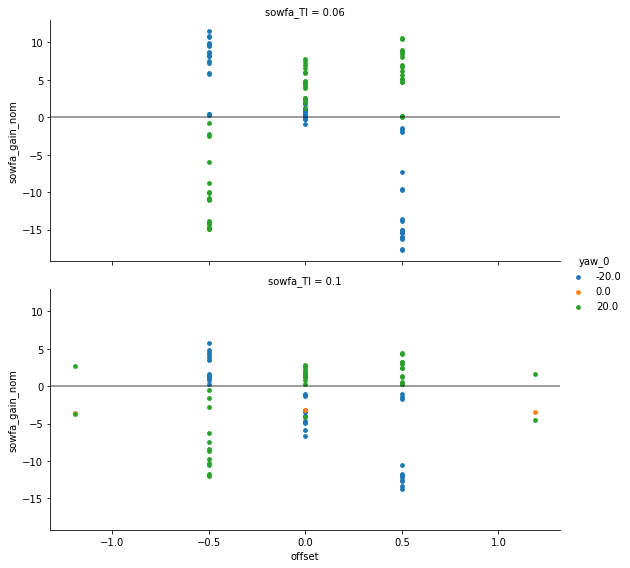

In [53]:
g = sns.FacetGrid(df_sub,row='sowfa_TI',hue='yaw_0',size=4,aspect=2)
g.map(plt.scatter,'offset','sowfa_gain_nom',s=14)
for ax in g.axes.flatten():
    ax.axhline(0,color='k',alpha=0.5)
g.add_legend()